# Modeling and Simulation in Python

Copyright 2018 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Modeling tree growth

This case study is based on "[Height-Age Curves for Planted Stands of Douglas Fir, with Adjustments for Density](http://www.cfr.washington.edu/research.smc/working_papers/smc_working_paper_1.pdf)", a working paper by Flewelling, Collier, Gonyea, Marshall, and Turnblom.

It provides "site index curves", which are curves that show the expected height of the tallest tree in a stand of Douglas firs as a function of age, for a stand where the trees are the same age.

Depending on the quality of the site, the trees might grow more quickly or slowing.  So each curve is identified by a "site index" that indicates the quality of the site.

I'll start with some of the data from their Table 1.  Here's the sequence of ages.

In [2]:
years = [2, 3, 4, 5, 6, 8, 10, 15, 20, 25, 30,
         35, 40, 45, 50, 55, 60, 65, 70]

[2, 3, 4, 5, 6, 8, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]

And here's the series of heights for a site with index 45, indicating that height at 30 years is 45 feet.

In [3]:
site45 = TimeSeries([1.4, 1.49, 1.75, 2.18, 2.78, 4.45, 6.74,
                    14.86, 25.39, 35.60, 45.00, 53.65, 61.60,
                    68.92, 75.66, 81.85, 87.56, 92.8, 97.63],
                    index=years)

,values
2,1.40
3,1.49
4,1.75
5,2.18
6,2.78
8,4.45
10,6.74
15,14.86
20,25.39
25,35.60


Here's the series for site index 65.

In [4]:
site65 = TimeSeries([1.4, 1.56, 2.01, 2.76, 3.79, 6.64, 10.44, 
                    23.26, 37.65, 51.66, 65.00, 77.50, 89.07, 
                    99.66, 109.28, 117.96, 125.74, 132.68, 138.84],
                    index=years)

,values
2,1.40
3,1.56
4,2.01
5,2.76
6,3.79
8,6.64
10,10.44
15,23.26
20,37.65
25,51.66


And for site index 85.

In [5]:
site85 = Series([1.4, 1.8, 2.71, 4.09, 5.92, 10.73, 16.81, 
                 34.03, 51.26, 68.54, 85, 100.34, 114.33,
                 126.91, 138.06, 147.86, 156.39, 163.76, 170.10],
               index=years)

2       1.40
3       1.80
4       2.71
5       4.09
6       5.92
8      10.73
10     16.81
15     34.03
20     51.26
25     68.54
30     85.00
35    100.34
40    114.33
45    126.91
50    138.06
55    147.86
60    156.39
65    163.76
70    170.10
dtype: float64

Here's what the curves look like:

Saving figure to file figs/trees-fig01.pdf


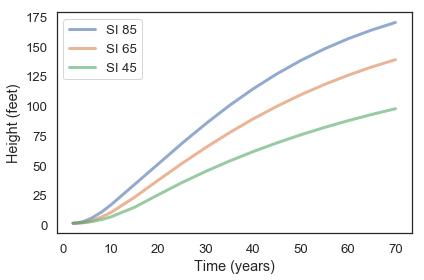

In [6]:
plot(site85, label='SI 85')
plot(site65, label='SI 65')
plot(site45, label='SI 45')
decorate(xlabel='Time (years)',
         ylabel='Height (feet)')

savefig('figs/trees-fig01.pdf')

For my examples I'll work with the SI 65 data; as an exercise, you can run the notebook again with either of the other curves.

In [7]:
data = site65;

### Model 1

As a starting place, let's assume that the ability of the tree to gain mass is limited by the area it exposes to sunlight, and that the growth rate (in mass) is proportional to that area.  In that case we can write:

$ m_{n+1} = m_n + \alpha A$

where $m_n$ is the mass of the at time step $n$, $A$ is the area exposed to sunlight, and $\alpha$ is an unknown growth parameter.

To get from $m$ to $A$, I'll make the additional assumption that mass is proportional to height raised to an unknown power:

$ m = \beta h^D $

where $h$ is height, $\beta$ is an unknown constant of proportionality, and $D$ is the dimension that relates height and mass.  

We'll start by assuming $D=3$, but we'll revisit that assumption.

Finally, we'll assume that area is proportional to height squared:

$ A = \gamma h^2$

I'll specify height in feet, and choose units for mass and area so that $\beta=1$ and $\gamma=1$.

Putting all that together, we can write a difference equation for height:

$ h_{n+1}^D = h_n^D + \alpha h_n^2 $

Now let's solve it.  Here's a system object with the parameters and initial conditions.

In [8]:
alpha = 7
dim = 3

t_0 = get_first_label(data)
t_end = get_last_label(data)

h_0 = get_first_value(data)

system = System(alpha=alpha, dim=dim, 
                h_0=h_0, t_0=t_0, t_end=t_end)

,values
alpha,7.0
dim,3.0
h_0,1.4
t_0,2.0
t_end,70.0


And here's an update function that takes the current height as a parameter and returns the height during the next time step.

In [9]:
def update(height, t, system):
    """Update height based on geometric model.
    
    height: current height in feet
    t: what year it is
    system: system object with model parameters
    """
    area = height**2
    mass = height**system.dim
    mass += system.alpha * area
    return mass**(1/system.dim)

Test the update function with the initial conditions.

In [10]:
update(h_0, t_0, system)

2.5439688299649954

Here's our usual version of `run_simulation`.

In [11]:
def run_simulation(system, update_func):
    """Simulate the system using any update function.
    
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.h_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = update_func(results[t], t, system)
        
    return results

And here's how we run it.

In [12]:
results = run_simulation(system, update)
results.tail()

66    140.497321
67    142.792941
68    145.089152
69    147.385935
70    149.683273
dtype: float64

Plot the results:

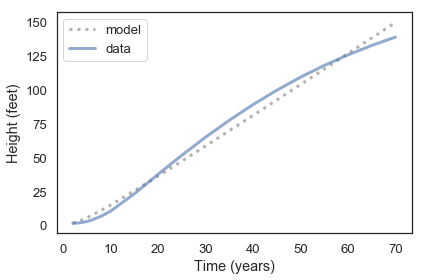

In [13]:
def plot_results(results, data):
    plot(results, ':', label='model', color='gray')
    plot(data, label='data')
    decorate(xlabel='Time (years)',
             ylabel='Height (feet)')
    
plot_results(results, data)

The result converges to a straight line.

I chose the value of `alpha` to fit the data as well as I could, but it is clear that the data have curvature that's not captured by the model.

Here are the errors:

In [14]:
errors = results - data
errors.dropna()

2      0.000000
3      0.983969
4      1.942915
5      2.792070
6      3.496882
8      4.387116
10     4.557437
15     2.194275
20    -1.346851
25    -4.304519
30    -6.468590
35    -7.709926
40    -7.962119
45    -7.189989
50    -5.413433
55    -2.669382
60     0.997125
65     5.522310
70    10.843273
dtype: float64

And here's the mean absolute error.

In [15]:
def mean_abs_error(results, data):
    return np.mean(np.abs(results-data))

mean_abs_error(results, data)

4.251693738559428

This model might explain why the height of a tree grows roughly linearly:

1. If area is proportional to $h^2$ and mass is proportional to $h^3$, and

2. Change in mass is proportional to area, and

3. Height grows linearly, then

4. Area grows in proportion to $h^2$, and

5. Mass grows in proportion to $h^3$.

If the goal is to explain (approximate) linear growth, we might stop there.  But this model does not fit the data particularly well, and it implies that trees could keep growing forever.

So we might want to do better.

### Model 2

As a second attempt, let's suppose that we don't know $D$.  In fact, we don't, because trees are not like simple solids; they are more like fractals, which have [fractal dimension](https://en.wikipedia.org/wiki/Fractal_dimension).

I would expect the fractal dimension of a tree to be between 2 and 3, so I'll guess 2.5.

In [16]:
alpha = 7
dim = 2.8

params = alpha, dim

(7, 2.8)

I'll wrap the code from the previous section is a function that takes the parameters as inputs and makes a `System` object.

In [17]:
def make_system(params, data):
    """Makes a System object.
    
    params: sequence of alpha, dim
    data: Series
    
    returns: System object
    """
    alpha, dim = params
    
    t_0 = get_first_label(data)
    t_end = get_last_label(data)

    h_0 = get_first_value(data)

    return System(alpha=alpha, dim=dim, 
                  h_0=h_0, t_0=t_0, t_end=t_end)

Here's how we use it.

In [18]:
system = make_system(params, data)

,values
alpha,7.0
dim,2.8
h_0,1.4
t_0,2.0
t_end,70.0


With different values for the parameters, we get curves with different behavior.  Here are a few that I chose by hand.

In [19]:
def run_and_plot(alpha, dim, data):
    params = alpha, dim
    system = make_system(params, data)
    results = run_simulation(system, update)
    plot(results, ':', color='gray')

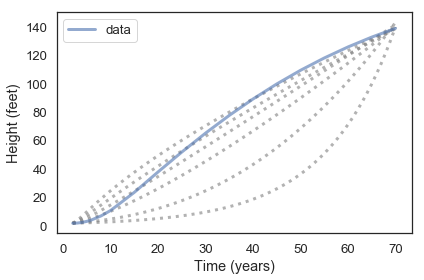

In [20]:
run_and_plot(0.145, 2, data)
run_and_plot(0.58, 2.4, data)
run_and_plot(2.8, 2.8, data)
run_and_plot(6.6, 3, data)
run_and_plot(15.5, 3.2, data)
run_and_plot(38, 3.4, data)

plot(data, label='data')
decorate(xlabel='Time (years)',
             ylabel='Height (feet)')

To find the parameters that best fit the data, I'll use `fit_leastsq`.

We need an error function that takes parameters and returns errors:

In [21]:
def error_func(params, data, update_func):
    """Runs the model and returns errors.
    
    params: sequence of alpha, dim
    data: Series
    update_func: function object
    
    returns: Series of errors
    """
    print(params)
    system = make_system(params, data)
    results = run_simulation(system, update_func)
    return (results - data).dropna()

Here's how we use it:

In [22]:
errors = error_func(params, data, update)

(7, 2.8)


2       0.000000
3       1.148852
4       2.494726
5       3.987474
6       5.596116
8       9.023410
10     12.588184
15     21.692189
20     32.897280
25     47.207627
30     64.370278
35     84.203833
40    106.551950
45    131.281973
50    158.242758
55    187.291743
60    218.296906
65    251.121491
70    285.640417
dtype: float64

Now we can pass `error_func` to `fit_leastsq`, which finds the parameters that minimize the squares of the errors.

In [23]:
best_params, details = fit_leastsq(error_func, params, data, update)
details

[7.  2.8]
[7.  2.8]
[7.  2.8]
[7.0000001 2.8      ]
[7.         2.80000004]
[6.92221274 2.90250933]
[6.92221284 2.90250933]
[6.92221274 2.90250937]
[9.09216749 3.04344998]
[9.09216762 3.04344998]
[9.09216749 3.04345003]
[11.32004185  3.11949616]
[11.32004202  3.11949616]
[11.32004185  3.11949621]
[11.45136397  3.11757873]
[11.45136414  3.11757873]
[11.45136397  3.11757877]
[11.4662145   3.11792116]
[11.46621467  3.11792116]
[11.4662145   3.11792121]
[11.46393756  3.11787313]
[11.46393773  3.11787313]
[11.46393756  3.11787318]
[11.46425723  3.11787985]


,values
fvec,"[0.0, 1.2594299990579172, 2.5891995448155054, ..."
nfev,22
fjac,"[[-1211.6163927810555, -0.0007452893438503401,..."
ipvt,"[2, 1]"
qtf,"[4.201876598530774e-05, 0.0006063193148584389]"
cov_x,"[[0.2779653954875504, 0.005806515296622473], [..."
mesg,Both actual and predicted relative reductions ...
ier,1


Using the best parameters we found, we can run the model and plot the results.

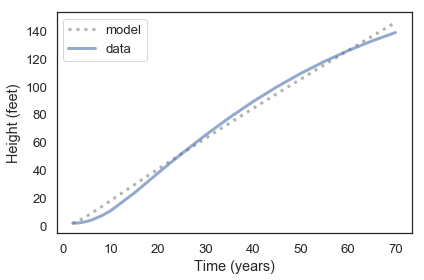

In [24]:
system = make_system(best_params, data)
results = run_simulation(system, update)

plot_results(results, data)

The mean absolute error is better than for Model 1, but that doesn't mean much.  The model still doesn't fit the data well.

In [25]:
mean_abs_error(results, data)

3.618490496547406

And the estimated fractal dimension is 3.11, which doesn't seem likely.

Let's try one more thing.

### Model 3

Models 1 and 2 imply that trees can grow forever, but we know that's not true.  As trees get taller, it gets harder for them to move water and nutrients against the force of gravity, and their growth slows.

We can model this effect by adding a term to the model similar to what we saw in the logistic model of population growth.  Instead of assuming:

$ m_{n+1} = m_n + \alpha A $ 

Let's assume

$ m_{n+1} = m_n + \alpha A (1 - h / K) $

where $K$ is similar to the carrying capacity of the logistic model.  As $h$ approaches $K$, the factor $(1 - h/K)$ goes to 0, causing growth to level off.

Here's what the implementation of this model looks like:

In [26]:
alpha = 2.0
dim = 2.5
K = 150

params = [alpha, dim, K]

[2.0, 2.5, 150]

Here's an updated version of `make_system`

In [27]:
def make_system(params, data):
    """Makes a System object.
    
    params: sequence of alpha, dim, K
    data: Series
    
    returns: System object
    """
    alpha, dim, K = params
    
    t_0 = get_first_label(data)
    t_end = get_last_label(data)

    h_0 = get_first_value(data)

    return System(alpha=alpha, dim=dim, K=K, 
                  h_0=h_0, t_0=t_0, t_end=t_end)

Here's the new `System` object.

In [28]:
system = make_system(params, data)

,values
alpha,2.0
dim,2.5
K,150.0
h_0,1.4
t_0,2.0
t_end,70.0


And here's the new update function.

In [29]:
def update3(height, t, system):
    """Update height based on geometric model with growth limiting term.
    
    height: current height in feet
    t: what year it is
    system: system object with model parameters
    """
    area = height**2
    mass = height**system.dim
    mass += system.alpha * area * (1 - height/system.K)
    return mass**(1/system.dim)

As always, we'll test the update function with the initial conditions.

In [30]:
update3(h_0, t_0, system)

2.075043351397076

Now we can test the error function with the new update function.

In [31]:
error_func(params, data, update3)

[2.0, 2.5, 150]


2      0.000000
3      0.515043
4      0.920001
5      1.216367
6      1.431972
8      1.685640
10     1.801190
15     1.975039
20     3.929748
25     7.701256
30    11.775782
35    15.027748
40    16.865948
45    17.173291
50    16.106566
55    13.967791
60    11.095254
65     7.785693
70     4.284147
dtype: float64

And search for the best parameters.

In [32]:
best_params, details = fit_leastsq(error_func, params, data, update3)
details

[  2.    2.5 150. ]
[  2.    2.5 150. ]
[  2.    2.5 150. ]
[  2.00000003   2.5        150.        ]
[  2.           2.50000004 150.        ]
[  2.           2.5        150.00000224]
[  2.57150998   2.62640233 152.85619548]
[  2.57151002   2.62640233 152.85619548]
[  2.57150998   2.62640237 152.85619548]
[  2.57150998   2.62640233 152.85619776]
[  2.69480843   2.64180464 164.38502739]
[  2.69480847   2.64180464 164.38502739]
[  2.69480843   2.64180468 164.38502739]
[  2.69480843   2.64180464 164.38502984]
[  2.69504996   2.64141868 165.06671302]
[  2.69505      2.64141868 165.06671302]
[  2.69504996   2.64141872 165.06671302]
[  2.69504996   2.64141868 165.06671548]
[  2.69600965   2.64152838 165.08460824]
[  2.69600969   2.64152838 165.08460824]
[  2.69600965   2.64152842 165.08460824]
[  2.69600965   2.64152838 165.0846107 ]
[  2.69593571   2.64152035 165.08358598]


,values
fvec,"[0.0, 0.6026560604027416, 1.1051308568507507, ..."
nfev,21
fjac,"[[-935.0854546680339, -0.0005819515127655662, ..."
ipvt,"[2, 1, 3]"
qtf,"[-1.813600263139703e-05, -0.000299855962060391..."
cov_x,"[[0.0348088168388554, 0.003865950604643208, 0...."
mesg,Both actual and predicted relative reductions ...
ier,1


With these parameters, we can fit the data much better.

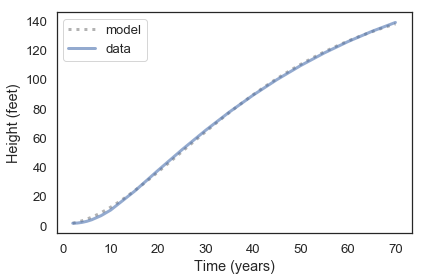

In [33]:
system = make_system(best_params, data)
results = run_simulation(system, update3)

plot_results(results, data)

And the mean absolute error is substantually smaller.

In [34]:
mean_abs_error(results, data)

0.8895329592918969

The estimated fractal dimension is about 2.6, which is plausible for a tree.

Basically, it suggests that if you double the height of the tree, the mass grows by a factor of $2^{2.6}$

In [35]:
2**2.6

6.062866266041593

In other words, the mass of the tree scales faster than area, but not as fast as it would for a solid 3-D object.

What is this model good for?

1) It offers a possible explanation for the shape of tree growth curves.

2) It provides a way to estimate the fractal dimension of a tree based on a growth curve (probably with different values for different species).

3) It might provide a way to predict future growth of a tree, based on measurements of past growth.  As with the logistic population model, this would probably only work if we have observed the part of the curve where the growth rate starts to decline.

### Analysis

With some help from my colleague, John Geddes, we can do some analysis.

Starting with the difference equation in terms of mass:
 
$m_{n+1} = m_n + \alpha A (1 - h / K) $

We can write the corresponding differential equation:

(1) $ \frac{dm}{dt} = \alpha A (1 - h / K) $

With

(2) $A = h^2$

and

(3) $m = h^D$

Taking the derivative of the last equation yields

(4) $\frac{dm}{dt} = D h^{D-1} \frac{dh}{dt}$

Combining (1), (2), and (4), we can write a differential equation for $h$:

(5) $\frac{dh}{dt} = \frac{\alpha}{D} h^{3-D} (1 - h/K)$

Now let's consider two cases:

* With infinite $K$, the factor $(1 - h/K)$ approaches 1, so we have Model 2.
* With finite $K$, we have Model 3.

#### Model 2

Within Model 2, we'll consider two special cases, with $D=2$ and $D=3$.

With $D=2$, we have

$\frac{dh}{dt} = \frac{\alpha}{2} h$

which yields exponential growth with parameter $\alpha/2$.

With $D=3$, we have Model 1, with this equation:

$\frac{dh}{dt} = \frac{\alpha}{3}$

which yields linear growth with parameter $\alpha/3$.

This result explains why Model 1 is linear.



#### Model 3

Within Model 3, we'll consider two special cases, with $D=2$ and $D=3$.

With $D=2$, we have

$\frac{dh}{dt} = \frac{\alpha}{2} h (1 - h/K)$

which yields logisitic growth with parameters $r = \alpha/2$ and $K$.

With $D=3$, we have

$\frac{dh}{dt} = \frac{\alpha}{3} (1 - h/K)$

which yields a first order step response; that is, it converges to $K$ like a negative exponential:

$ h(t) = c \exp(-\frac{\alpha}{3K} t) + K $

where $c$ is a constant that depends on the initial conditions.

In [36]:
alpha = 10
D = 3
K = 200
params = alpha, D, K
system = make_system(params, data)
results = run_simulation(system, update3);

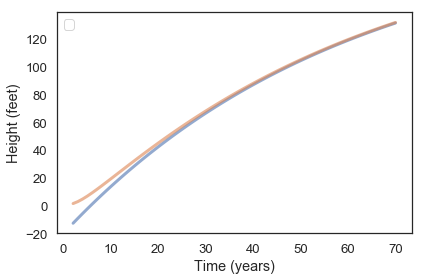

In [37]:
t = results.index
a = alpha/3
h = (-220) * exp(-a * t / K) + K
plot(t, h)
plot(results)
decorate(xlabel='Time (years)',
         ylabel='Height (feet)')

Additional resources:

Garcia, [A stochastic differential equation model for the
height growth of forest stands](http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=664FED1E46ABCBF6E16741C294B79976?doi=10.1.1.608.81&rep=rep1&type=pdf)

[EasySDE software and data](http://forestgrowth.unbc.ca/)